# Data Science Capstone Project

## Introduction/Business Problem

An enthusiastic young chef plans to open a new high-end Mexican restaurant in New York City. In order for the business to be a success, the chef wants to find the perfect location. In order to find the best location, the chef wants answers to the following questions.
* Are there any similar restaurants already open in New York City, and if so, where are they?
* What kinds of neighborhoods are the existing Mexican restaurants in, and what neighborhoods are most similar?
* Are there any neighborhoods that are similar to those with existing Mexican restaurants that don't currently have a Mexican restaurant?

## Data

We will use the following sources of data for this project.

* Foursquare venue data via the Foursquare api
* New York City neighborhood data from NYU as used in the neighborhood project earlier in the capstone course
* Maps from the folium library in python
* Location data geopy library

We will load in all of the necessary libraries before gathering data.

In [37]:
# Import necessary libraries
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Json data handling libraries
import json
from pandas.io.json import json_normalize

# Mapping package
import folium

# Library to handle requests for the foursquare api
import requests

# Library to look up location data
from geopy.geocoders import Nominatim

# K-means clustering package from scikit-learn
from sklearn.cluster import KMeans

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

### Neighborhood data

First, we download the New York neighborhood data provided at https://geo.nyu.edu/catalog/nyu_2451_34572. The data will be accessed via the same server that we used in the earlier project.

In [2]:
!curl -q -o 'newyork_data.json' https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DP0701EN/data/nyu_2451_34572-geojson.json
print('Data downloaded!')

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  113k  100  113k    0     0   345k      0 --:--:-- --:--:-- --:--:--  345k
Data downloaded!


Next, we perform the necessary manipulations to translate the json file into a more useful pandas dataframe.

In [3]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

# All of the data we need is in the features key
neighborhoods_data = newyork_data['features']

# Define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# Instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

# Load data into the dataframe from the json file
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

# View the head of the new dataframe
neighborhoods.head()

Borough Neighborhood   Latitude  Longitude
0   Bronx    Wakefield  40.894705 -73.847201
1   Bronx   Co-op City  40.874294 -73.829939
2   Bronx  Eastchester  40.887556 -73.827806
3   Bronx    Fieldston  40.895437 -73.905643
4   Bronx    Riverdale  40.890834 -73.912585

### Geopy location data

We will use geopy to find the latitude and longitude of New York City

In [4]:
# Define the location we are interested in
address = 'New York City, NY'

# Look up and save lat/long data for NYC
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


### Folium maps

We will use folium to create informative graphics to help the client make his decision. Here is an example of a map of NYC

In [5]:
# Create a map of NYC using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# Display the map
map_newyork

### Foursquare data

In order to use the foursquare api, we will need a client id and secret. This will be deleted before the notebook is published.

In [6]:
CLIENT_ID = 'J2P31F0NIFPJ3MTXEREH2Y24KPR2HM1LQR4SJXTVAWYGNRZG' # your Foursquare ID
CLIENT_SECRET = 'NA30SGGRBLUSHF2C42GTLXBKGGCFNUGL41GTU5EB2SIGASHQ' # your Foursquare Secret
VERSION = '20200720' # Foursquare API version

# Set the limit on number of venues looked up and the radius around each neighborhood to search
LIMIT = 100
radius = 500

We will use the following function to gather venue data for the neighborhoods of NYC

In [7]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [8]:
nyc_venues = getNearbyVenues(neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude']
                                  )

Wakefield
Co-op City
Eastchester
Fieldston
Riverdale
Kingsbridge
Marble Hill
Woodlawn
Norwood
Williamsbridge
Baychester
Pelham Parkway
City Island
Bedford Park
University Heights
Morris Heights
Fordham
East Tremont
West Farms
High  Bridge
Melrose
Mott Haven
Port Morris
Longwood
Hunts Point
Morrisania
Soundview
Clason Point
Throgs Neck
Country Club
Parkchester
Westchester Square
Van Nest
Morris Park
Belmont
Spuyten Duyvil
North Riverdale
Pelham Bay
Schuylerville
Edgewater Park
Castle Hill
Olinville
Pelham Gardens
Concourse
Unionport
Edenwald
Bay Ridge
Bensonhurst
Sunset Park
Greenpoint
Gravesend
Brighton Beach
Sheepshead Bay
Manhattan Terrace
Flatbush
Crown Heights
East Flatbush
Kensington
Windsor Terrace
Prospect Heights
Brownsville
Williamsburg
Bushwick
Bedford Stuyvesant
Brooklyn Heights
Cobble Hill
Carroll Gardens
Red Hook
Gowanus
Fort Greene
Park Slope
Cypress Hills
East New York
Starrett City
Canarsie
Flatlands
Mill Island
Manhattan Beach
Coney Island
Bath Beach
Borough Park
Dyker

In [9]:
nyc_venues.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0    Wakefield              40.894705              -73.847201   
1    Wakefield              40.894705              -73.847201   
2    Wakefield              40.894705              -73.847201   
3    Wakefield              40.894705              -73.847201   
4    Wakefield              40.894705              -73.847201   

              Venue  Venue Latitude  Venue Longitude  Venue Category  
0  Lollipops Gelato       40.894123       -73.845892    Dessert Shop  
1         Walgreens       40.896528       -73.844700        Pharmacy  
2  Carvel Ice Cream       40.890487       -73.848568  Ice Cream Shop  
3          Rite Aid       40.896649       -73.844846        Pharmacy  
4           Dunkin'       40.890459       -73.849089      Donut Shop

Before moving on, we will create a table containing all of the Mexican restaurants from our dataset.

In [10]:
mex_rest = nyc_venues[nyc_venues['Venue Category'].str.contains('Mexican Restaurant')]
mex_rest.reset_index(drop=True, inplace=True)
mex_rest.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0  Kingsbridge              40.881687              -73.902818   
1  Kingsbridge              40.881687              -73.902818   
2  Kingsbridge              40.881687              -73.902818   
3      Norwood              40.877224              -73.879391   
4   Baychester              40.866858              -73.835798   

                                Venue  Venue Latitude  Venue Longitude  \
0                Estrellita Poblana V       40.879687       -73.906257   
1  Picante Picante Mexican Restaurant       40.878252       -73.902936   
2              Chipotle Mexican Grill       40.884566       -73.900474   
3                      Queen of Tacos       40.880200       -73.883434   
4               Moe's Southwest Grill       40.866310       -73.830320   

       Venue Category  
0  Mexican Restaurant  
1  Mexican Restaurant  
2  Mexican Restaurant  
3  Mexican Restaurant  
4  Mexican Restaurant

In [11]:
mex_rest.shape

(175, 7)

## Methodology

### Question 1

Since the chef is planning to open a high-end restaurant, we will sort out restaurant chains. These are not relevant to our business problem. First, we look at the restaurants with multiple locations.

In [12]:
mex_rest['Venue'].value_counts()

Chipotle Mexican Grill                            18
Maizal                                             2
QDOBA Mexican Eats                                 2
Cinco de Mayo                                      2
Gran Eléctrica                                     2
Moe's Southwest Grill                              2
Taco Truck                                         2
Rosa Mexicano                                      2
Los Tres Chiflados                                 2
Baby Bo's Cantina                                  2
Tacombi                                            2
La Esquina                                         2
Tacos Mi Mexico Lindo                              2
Lupita's Restaurant                                2
Estrellita Poblana                                 1
Azteca                                             1
Agave Mexican & American Grill                     1
Taco Veloz                                         1
El Rio Grande                                 

We will filter out Chipotle, Moe's Southwest Grill, and Qdoba, as these are national chains of casual restaurants. Further research may identify more chains. We also remove Taco Truck from the data since food trucks are not relevant.

In [13]:
# Filter out Chipotle
mex_rest = mex_rest[mex_rest['Venue'].str.contains('Chipotle Mexican') == False]
mex_rest.reset_index(drop=True, inplace=True)

# Filter out Moe's
mex_rest = mex_rest[mex_rest['Venue'].str.contains("Moe's Southwest") == False]
mex_rest.reset_index(drop=True, inplace=True)

# Filter out Qdoba
mex_rest = mex_rest[mex_rest['Venue'].str.contains('QDOBA') == False]
mex_rest.reset_index(drop=True, inplace=True)

mex_rest = mex_rest[mex_rest['Venue'].str.contains('Qdoba') == False]
mex_rest.reset_index(drop=True, inplace=True)

# Filter out Taco Truck
mex_rest = mex_rest[mex_rest['Venue'].str.contains('Taco Truck') == False]
mex_rest.reset_index(drop=True, inplace=True)

# Print the dataframe
mex_rest

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0             Kingsbridge              40.881687              -73.902818   
1             Kingsbridge              40.881687              -73.902818   
2                 Norwood              40.877224              -73.879391   
3          Pelham Parkway              40.857413              -73.854756   
4            Bedford Park              40.870185              -73.885512   
5            Bedford Park              40.870185              -73.885512   
6            Bedford Park              40.870185              -73.885512   
7            Bedford Park              40.870185              -73.885512   
8                 Fordham              40.860997              -73.896427   
9                 Melrose              40.819754              -73.909422   
10            Parkchester              40.837938              -73.856003   
11     Westchester Square              40.840619              -73.842194   
12                Belmont              40.857277              -73.888452   
13        North Riverdale              40.908543              -73.904531   
14             Pelham Bay              40.850641              -73.832074   
15          Schuylerville              40.826580              -73.826203   
16          Schuylerville              40.826580              -73.826203   
17              Bay Ridge              40.625801              -74.030621   
18            Sunset Park              40.645103              -74.010316   
19            Sunset Park              40.645103              -74.010316   
20            Sunset Park              40.645103              -74.010316   
21             Greenpoint              40.730201              -73.954241   
22             Greenpoint              40.730201              -73.954241   
23             Greenpoint              40.730201              -73.954241   
24               Flatbush              40.636326              -73.958401   
25               Flatbush              40.636326              -73.958401   
26             Kensington              40.642382              -73.980421   
27       Prospect Heights              40.676822              -73.964859   
28       Prospect Heights              40.676822              -73.964859   
29       Prospect Heights              40.676822              -73.964859   
30       Prospect Heights              40.676822              -73.964859   
31       Prospect Heights              40.676822              -73.964859   
32               Bushwick              40.698116              -73.925258   
33               Bushwick              40.698116              -73.925258   
34               Bushwick              40.698116              -73.925258   
35               Bushwick              40.698116              -73.925258   
36               Bushwick              40.698116              -73.925258   
37       Brooklyn Heights              40.695864              -73.993782   
38       Brooklyn Heights              40.695864              -73.993782   
39            Cobble Hill              40.687920              -73.998561   
40                Gowanus              40.673931              -73.994441   
41                Gowanus              40.673931              -73.994441   
42            Fort Greene              40.688527              -73.972906   
43             Park Slope              40.672321              -73.977050   
44           Clinton Hill              40.693229              -73.967843   
45           Clinton Hill              40.693229              -73.967843   
46           Clinton Hill              40.693229              -73.967843   
47             Ocean Hill              40.678403              -73.913068   
48    Prospect Park South              40.647009              -73.962613   
49    Prospect Park South              40.647009              -73.962613   
50      East Williamsburg              40.708492              -73.938858   
51      East Williamsburg              40.708492             

### Question 2

In order to answer the second question for the client, we need to begin by clustering all of the neighborhoods of NYC. We build a ranking of the ten most common category of venue for each of the neighborhoods. The we cluster the neighborhoods using this data to find neighborhoods that contain the same kinds of venues.

In [14]:
# one hot encoding
nyc_onehot = pd.get_dummies(nyc_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
nyc_onehot['Neighborhood'] = nyc_venues['Neighborhood'] 

# Find the index for neighborhood
index = 0
for i, item in enumerate(nyc_onehot.columns):
    if item == 'Neighborhood':
        index = i

# move neighborhood column to the first column
fixed_columns = [nyc_onehot.columns[index]] + list(nyc_onehot.columns[:index]) + list(nyc_onehot.columns[index+1:])
nyc_onehot = nyc_onehot[fixed_columns]

nyc_onehot.head()

Neighborhood  Accessories Store  Adult Boutique  Afghan Restaurant  \
0    Wakefield                  0               0                  0   
1    Wakefield                  0               0                  0   
2    Wakefield                  0               0                  0   
3    Wakefield                  0               0                  0   
4    Wakefield                  0               0                  0   

   African Restaurant  Airport Terminal  American Restaurant  Antique Shop  \
0                   0                 0                    0             0   
1                   0                 0                    0             0   
2                   0                 0                    0             0   
3                   0                 0                    0             0   
4                   0                 0                    0             0   

   Arcade  Arepa Restaurant  Argentinian Restaurant  Art Gallery  Art Museum  \
0       0                 0                       0            0           0   
1       0                 0                       0            0           0   
2       0                 0                       0            0           0   
3       0                 0                       0            0           0   
4       0                 0                       0            0           0   

   Arts & Crafts Store  Arts & Entertainment  Asian Restaurant  \
0                    0                     0                 0   
1                    0                     0                 0   
2                    0                     0                 0   
3                    0                     0                 0   
4                    0                     0                 0   

   Athletics & Sports  Auditorium  Australian Restaurant  Austrian Restaurant  \
0                   0           0                      0                    0   
1                   0           0                      0                    0   
2                   0           0                      0                    0   
3                   0           0                      0                    0   
4                   0           0                      0                    0   

   Auto Workshop  Automotive Shop  BBQ Joint  Baby Store  Bagel Shop  Bakery  \
0              0                0          0           0           0       0   
1              0                0          0           0           0       0   
2              0                0          0           0           0       0   
3              0                0          0           0           0       0   
4              0                0          0           0           0       0   

   Bank  Bar  Baseball Field  Baseball Stadium  Basketball Court  \
0     0    0               0                 0                 0   
1     0    0               0                 0                 0   
2     0    0               0                 0                 0   
3     0    0               0                 0                 0   
4     0    0               0                 0                 0   

   Basketball Stadium  Bath House  Beach  Beach Bar  Bed & Breakfast  \
0                   0           0      0          0                0   
1                   0           0      0          0                0   
2                   0           0      0          0                0   
3                   0           0      0          0                0   
4                   0           0      0          0                0   

   Beer Bar  Beer Garden  Beer Store  Big Box Store  Bike Rental / Bike Share  \
0         0            0           0              0                         0   
1         0            0           0              0                         0   
2         0            0           0              0                         0   
3         0            0           0              0                         0   
4      

In [15]:
nyc_onehot.shape

(10060, 425)

In [16]:
nyc_grouped = nyc_onehot.groupby('Neighborhood').mean().reset_index()
nyc_grouped

Neighborhood  Accessories Store  Adult Boutique  \
0                     Allerton           0.000000            0.00   
1                     Annadale           0.000000            0.00   
2                Arden Heights           0.000000            0.00   
3                    Arlington           0.000000            0.00   
4                     Arrochar           0.000000            0.00   
5                      Arverne           0.000000            0.00   
6                      Astoria           0.000000            0.00   
7              Astoria Heights           0.000000            0.00   
8                   Auburndale           0.000000            0.00   
9                   Bath Beach           0.000000            0.00   
10           Battery Park City           0.000000            0.00   
11                   Bay Ridge           0.000000            0.00   
12                 Bay Terrace           0.021739            0.00   
13                  Baychester           0.000000            0.00   
14                     Bayside           0.000000            0.00   
15                   Bayswater           0.000000            0.00   
16                Bedford Park           0.000000            0.00   
17          Bedford Stuyvesant           0.000000            0.00   
18                  Beechhurst           0.000000            0.00   
19                    Bellaire           0.000000            0.00   
20                Belle Harbor           0.000000            0.00   
21                   Bellerose           0.000000            0.00   
22                     Belmont           0.000000            0.00   
23                 Bensonhurst           0.000000            0.00   
24                Bergen Beach           0.000000            0.00   
25                  Blissville           0.000000            0.00   
26                  Bloomfield           0.000000            0.00   
27                 Boerum Hill           0.000000            0.00   
28                Borough Park           0.000000            0.00   
29                Breezy Point           0.000000            0.00   
30                   Briarwood           0.000000            0.00   
31              Brighton Beach           0.000000            0.00   
32               Broad Channel           0.000000            0.00   
33           Broadway Junction           0.000000            0.00   
34                   Bronxdale           0.000000            0.00   
35            Brooklyn Heights           0.000000            0.00   
36                  Brookville           0.000000            0.00   
37                 Brownsville           0.000000            0.00   
38                  Bulls Head           0.000000            0.00   
39                    Bushwick           0.000000            0.00   
40                Butler Manor           0.000000            0.00   
41             Cambria Heights           0.000000            0.00   
42                    Canarsie           0.000000            0.00   
43               Carnegie Hill           0.000000            0.00   
44             Carroll Gardens           0.000000            0.00   
45                 Castle Hill           0.000000            0.00   
46           Castleton Corners           0.000000            0.00   
47              Central Harlem           0.000000            0.00   
48                  Charleston           0.000000            0.00   
49                     Chelsea           0.000000            0.00   
50                   Chinatown           0.000000            0.00   
51                 City Island           0.000000            0.00   
52                   City Line           0.000000            0.00   
53                Civic Center           0.000000            0.00   
54           Claremont Village           0.000000            0.00   
55                Clason Point           0.000000            0.00   
56                     Clifton           0.000000            0.00   
57              

In [17]:
nyc_grouped.shape

(302, 425)

In [18]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [19]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = nyc_grouped['Neighborhood']

for ind in np.arange(nyc_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(nyc_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
0       Allerton           Pizza Place    Chinese Restaurant   
1       Annadale   American Restaurant          Dance Studio   
2  Arden Heights              Pharmacy           Pizza Place   
3      Arlington          Intersection         Grocery Store   
4       Arrochar              Bus Stop         Deli / Bodega   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0         Deli / Bodega           Supermarket   Rental Car Location   
1                   Pub          Liquor Store         Train Station   
2              Bus Stop           Coffee Shop         Deli / Bodega   
3         Deli / Bodega         Boat or Ferry   American Restaurant   
4    Italian Restaurant        Cosmetics Shop            Bagel Shop   

  6th Most Common Venue 7th Most Common Venue  8th Most Common Venue  \
0            Bike Trail    Mexican Restaurant          Grocery Store   
1                  Park                  Food            Pizza Place   
2                 Diner            Eye Doctor     Falafel Restaurant   
3              Bus Stop                 Field      Fish & Chips Shop   
4        Sandwich Place           Pizza Place  Outdoors & Recreation   

        9th Most Common Venue 10th Most Common Venue  
0       Check Cashing Service   Fast Food Restaurant  
1                       Diner             Restaurant  
2                        Farm         Farmers Market  
3  Financial or Legal Service    Filipino Restaurant  
4          Athletics & Sports      Polish Restaurant

The next step is to use k-means clustering to group the neighborhoods together. Since NYC is a diverse city, we choose a large number of clusters (40) to use in the algorithm.

In [20]:
# set number of clusters
kclusters = 40

nyc_grouped_clustering = nyc_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(nyc_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([ 4, 13, 30, 32, 25,  4,  3, 32, 39, 29, 39,  4,  1,  1,  4, 23,  4,
        3,  4, 21, 35, 25, 25,  4,  9, 21, 36,  3, 29, 27, 32,  4, 34,  1,
        4, 39, 10, 21,  4,  3, 22, 21, 21, 39, 39, 29,  0, 39, 39, 39, 39,
        3, 29, 39, 32, 13, 32, 39,  4, 29,  3,  4, 32, 21,  1, 14,  4, 32,
       32,  1,  4,  4, 29, 39, 39, 13,  1, 21,  4, 21, 34,  3,  3, 21, 12,
       21, 25, 24, 25,  4,  4, 31, 21, 21, 21, 39, 29, 39, 21,  4, 39, 29,
        4, 32, 39,  4, 17, 21, 13, 29,  3, 29, 34,  3,  3, 11,  4, 32,  4,
        4,  3,  4, 39,  7,  4, 27,  3, 21, 32,  1, 39,  1, 29,  4,  2, 39,
       29, 39, 32,  4,  4,  1, 26, 29, 32,  4, 32,  4,  4, 21,  1, 39, 28,
       39, 32, 39,  4,  3, 29,  4,  4, 18, 32,  0,  3,  3, 21, 39, 29, 25,
       29, 29,  4, 35, 39, 39, 34,  4,  5, 13, 32, 34, 29, 29, 29, 32, 39,
       15, 13,  4, 25, 21,  4, 39, 32,  4,  3, 29,  4,  3, 32, 32, 25,  1,
       29,  8, 30, 39,  1, 29, 21,  4, 29,  4, 16,  3, 34,  4,  3, 32,  1,
        1, 21, 39, 30,  4

In [21]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

nyc_merged = neighborhoods

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
nyc_merged = nyc_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

nyc_merged.dropna(inplace=True)

nyc_merged

Borough               Neighborhood   Latitude  Longitude  \
0            Bronx                  Wakefield  40.894705 -73.847201   
1            Bronx                 Co-op City  40.874294 -73.829939   
2            Bronx                Eastchester  40.887556 -73.827806   
3            Bronx                  Fieldston  40.895437 -73.905643   
4            Bronx                  Riverdale  40.890834 -73.912585   
5            Bronx                Kingsbridge  40.881687 -73.902818   
6        Manhattan                Marble Hill  40.876551 -73.910660   
7            Bronx                   Woodlawn  40.898273 -73.867315   
8            Bronx                    Norwood  40.877224 -73.879391   
9            Bronx             Williamsbridge  40.881039 -73.857446   
10           Bronx                 Baychester  40.866858 -73.835798   
11           Bronx             Pelham Parkway  40.857413 -73.854756   
12           Bronx                City Island  40.847247 -73.786488   
13           Bronx               Bedford Park  40.870185 -73.885512   
14           Bronx         University Heights  40.855727 -73.910416   
15           Bronx             Morris Heights  40.847898 -73.919672   
16           Bronx                    Fordham  40.860997 -73.896427   
17           Bronx               East Tremont  40.842696 -73.887356   
18           Bronx                 West Farms  40.839475 -73.877745   
19           Bronx               High  Bridge  40.836623 -73.926102   
20           Bronx                    Melrose  40.819754 -73.909422   
21           Bronx                 Mott Haven  40.806239 -73.916100   
22           Bronx                Port Morris  40.801664 -73.913221   
23           Bronx                   Longwood  40.815099 -73.895788   
24           Bronx                Hunts Point  40.809730 -73.883315   
25           Bronx                 Morrisania  40.823592 -73.901506   
26           Bronx                  Soundview  40.821012 -73.865746   
27           Bronx               Clason Point  40.806551 -73.854144   
28           Bronx                Throgs Neck  40.815109 -73.816350   
29           Bronx               Country Club  40.844246 -73.824099   
30           Bronx                Parkchester  40.837938 -73.856003   
31           Bronx         Westchester Square  40.840619 -73.842194   
32           Bronx                   Van Nest  40.843608 -73.866299   
33           Bronx                Morris Park  40.847549 -73.850402   
34           Bronx                    Belmont  40.857277 -73.888452   
35           Bronx             Spuyten Duyvil  40.881395 -73.917190   
36           Bronx            North Riverdale  40.908543 -73.904531   
37           Bronx                 Pelham Bay  40.850641 -73.832074   
38           Bronx              Schuylerville  40.826580 -73.826203   
39           Bronx             Edgewater Park  40.821986 -73.813885   
40           Bronx                Castle Hill  40.819014 -73.848027   
41           Bronx                  Olinville  40.871371 -73.863324   
42           Bronx             Pelham Gardens  40.862966 -73.841612   
43           Bronx                  Concourse  40.834284 -73.915589   
44           Bronx                  Unionport  40.829774 -73.850535   
45           Bronx                   Edenwald  40.884561 -73.848083   
46        Brooklyn                  Bay Ridge  40.625801 -74.030621   
47        Brooklyn                Bensonhurst  40.611009 -73.995180   
48        Brooklyn                Sunset Park  40.645103 -74.010316   
49        Brooklyn                 Greenpoint  40.730201 -73.954241   
50        Brooklyn                  Gravesend  40.595260 -73.973471   
51        Brooklyn             Brighton Beach  40.576825 -73.965094   
52        Brooklyn             Sheepshead Bay  40.586890 -73.943186   
53        Brooklyn          Manhattan Terrace  40.614433 -73.957438   
54        Brooklyn                   Flatbush  40.636326 -73.958401   
55        Brooklyn              Cro

Now we can generate a map of the neighborhoods color coded by cluster.

In [22]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(nyc_merged['Latitude'], nyc_merged['Longitude'], nyc_merged['Neighborhood'], nyc_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [23]:
# Add cluster labels to Mexican restaurant table
labels_df = nyc_merged.loc[:, ['Neighborhood', 'Cluster Labels']]
mex_rest = mex_rest.merge(labels_df, on='Neighborhood')

In [24]:
mex_rest['Cluster Labels'].value_counts()

4     47
3     41
39    33
29    14
32     7
1      6
25     2
13     2
35     1
Name: Cluster Labels, dtype: int64

## Results

### Question 1: Are there any similar restaurants already open in New York City, and if so, where are they?

To answer this question, we provide a map of the data from the table of Mexican restaurants.

In [26]:
# create map of NYC's Mexican restaurants using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, venue, neighborhood in zip(mex_rest['Venue Latitude'], mex_rest['Venue Longitude'], mex_rest['Venue'], mex_rest['Neighborhood']):
    label = '{}, {}'.format(neighborhood, venue)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

### Question 2: What kinds of neighborhoods are the existing Mexican restaurants in, and what neighborhoods are most similar?

To answer this question, we provide our client with a map of the Mexican restaurants of NYC color coded by cluster.

In [108]:
# create map
res_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(mex_rest['Venue Latitude'], mex_rest['Venue Longitude'], mex_rest['Venue'], mex_rest['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(res_clusters)
       
res_clusters

To give a clear picture of the distrubution of restaurants among the clusters, we can observe the number of Mexican restaurants in each cluster from the following bar chart.

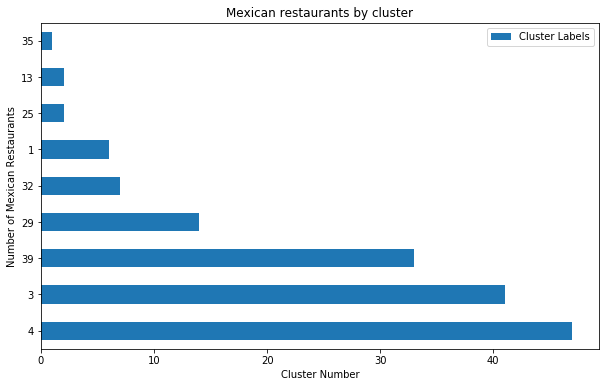

79.08 percent of the Mexican restaurants are contained in clusters 4, 3, and 39.


In [107]:
# Make a dataframe containing the the frequency data
val_counts = pd.DataFrame(mex_rest['Cluster Labels'].value_counts())

# Make the bar chart
val_counts.plot(kind='barh', figsize=(10,6))
plt.title('Mexican restaurants by cluster')
plt.xlabel('Cluster Number')
plt.ylabel('Number of Mexican Restaurants')

plt.show()

print('{:0.2f} percent of the Mexican restaurants are contained in clusters {}, {}, and {}.'.format(
    100*(val_counts.iloc[0:3,0].sum())/val_counts.iloc[:,0].sum(),
    val_counts.index[0],
    val_counts.index[1],
    val_counts.index[2]
    ))

We give the client a snapshot of each of the top threes clusters by showing the first ten neighborhoods in each along with their most common kinds of venues.

In [94]:
cluster4_df = nyc_merged[nyc_merged['Cluster Labels']==4]
cluster3_df = nyc_merged[nyc_merged['Cluster Labels']==3]
cluster39_df = nyc_merged[nyc_merged['Cluster Labels']==39]

Venue data for first 10 neighborhoods in cluster 4.

In [95]:
cluster4_df.head(10)

Borough     Neighborhood   Latitude  Longitude  Cluster Labels  \
5      Bronx      Kingsbridge  40.881687 -73.902818               4   
11     Bronx   Pelham Parkway  40.857413 -73.854756               4   
13     Bronx     Bedford Park  40.870185 -73.885512               4   
36     Bronx  North Riverdale  40.908543 -73.904531               4   
46  Brooklyn        Bay Ridge  40.625801 -74.030621               4   
47  Brooklyn      Bensonhurst  40.611009 -73.995180               4   
50  Brooklyn        Gravesend  40.595260 -73.973471               4   
51  Brooklyn   Brighton Beach  40.576825 -73.965094               4   
52  Brooklyn   Sheepshead Bay  40.586890 -73.943186               4   
84  Brooklyn     Clinton Hill  40.693229 -73.967843               4   

          1st Most Common Venue 2nd Most Common Venue  \
5                   Pizza Place                   Bar   
11           Italian Restaurant           Pizza Place   
13                        Diner    Mexican Restaurant   
36                  Pizza Place    Italian Restaurant   
46                          Spa    Italian Restaurant   
47           Italian Restaurant        Ice Cream Shop   
50                  Pizza Place    Italian Restaurant   
51  Eastern European Restaurant    Russian Restaurant   
52                 Dessert Shop    Turkish Restaurant   
84                  Pizza Place    Italian Restaurant   

        3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
5   Latin American Restaurant           Supermarket    Mexican Restaurant   
11         Frozen Yogurt Shop           Gas Station            Donut Shop   
13                Pizza Place        Sandwich Place           Supermarket   
36         Chinese Restaurant                  Bank            Donut Shop   
46                Pizza Place                   Bar            Bagel Shop   
47              Grocery Store      Sushi Restaurant    Chinese Restaurant   
50         Chinese Restaurant                Bakery                Lounge   
51                 Restaurant                 Beach                  Bank   
52             Sandwich Place           Yoga Studio        Ice Cream Shop   
84         Mexican Restaurant             Wine Shop       Thai Restaurant   

     6th Most Common Venue  7th Most Common Venue 8th Most Common Venue  \
5                   Bakery               Pharmacy            Donut Shop   
11           Metro Station  Performing Arts Venue    Chinese Restaurant   
13      Chinese Restaurant          Deli / Bodega    Italian Restaurant   
36           Grocery Store           Burger Joint           Coffee Shop   
46     American Restaurant       Greek Restaurant        Sandwich Place   
47              Donut Shop            Pizza Place               Butcher   
50  Furniture / Home Store            Music Venue           Fish Market   
51       Mobile Phone Shop       Sushi Restaurant          Gourmet Shop   
52      Russian Restaurant            Pizza Place         Grocery Store   
84    Caribbean Restaurant    Japanese Restaurant            Restaurant   

   9th Most Common Venue 10th Most Common Venue  
5         Sandwich Place    Fried Chicken Joint  
11           Coffee Shop             Eye Doctor  
13    Spanish Restaurant         Baseball Field  
36            Bagel Shop         Sandwich Place  
46    Chinese Restaurant          Grocery Store  
47                Bakery            Record Shop  
50         Metro Station                    Bar  
51   Varenyky restaurant                 Lounge  
52                  Café        Harbor / Marina  
84           Yoga Studio                  Diner

In [96]:
cluster4_df['Borough'].value_counts()

Queens           20
Staten Island    12
Brooklyn         10
Bronx             7
Manhattan         4
Name: Borough, dtype: int64

Venue data for first 10 neighborhoods in cluster 3.

In [97]:
cluster3_df.head(10)

Borough        Neighborhood   Latitude  Longitude  Cluster Labels  \
12     Bronx         City Island  40.847247 -73.786488               3   
22     Bronx         Port Morris  40.801664 -73.913221               3   
49  Brooklyn          Greenpoint  40.730201 -73.954241               3   
59  Brooklyn    Prospect Heights  40.676822 -73.964859               3   
61  Brooklyn        Williamsburg  40.707144 -73.958115               3   
62  Brooklyn            Bushwick  40.698116 -73.925258               3   
63  Brooklyn  Bedford Stuyvesant  40.687232 -73.941785               3   
65  Brooklyn         Cobble Hill  40.687920 -73.998561               3   
67  Brooklyn            Red Hook  40.676253 -74.012759               3   
68  Brooklyn             Gowanus  40.673931 -73.994441               3   

     1st Most Common Venue   2nd Most Common Venue      3rd Most Common Venue  \
12           Deli / Bodega  Thrift / Vintage Store         Seafood Restaurant   
22  Furniture / Home Store        Storage Facility  Latin American Restaurant   
49                     Bar             Pizza Place                Coffee Shop   
59                     Bar      Mexican Restaurant                  Wine Shop   
61                     Bar             Coffee Shop                Pizza Place   
62                     Bar             Coffee Shop         Mexican Restaurant   
63             Coffee Shop                     Bar                Pizza Place   
65                     Bar              Playground               Cocktail Bar   
67      Seafood Restaurant                     Bar                       Park   
68      Italian Restaurant                     Bar     Furniture / Home Store   

   4th Most Common Venue 5th Most Common Venue          6th Most Common Venue  \
12       Harbor / Marina         Jewelry Store              French Restaurant   
22               Brewery    Spanish Restaurant  Paper / Office Supplies Store   
49          Cocktail Bar           Yoga Studio                           Café   
59          Cocktail Bar                Bakery                Thai Restaurant   
61            Bagel Shop           Yoga Studio                 Breakfast Spot   
62         Deli / Bodega                Bakery         Thrift / Vintage Store   
63                  Café          Cocktail Bar                       Boutique   
65           Coffee Shop           Yoga Studio                    Pizza Place   
67           Art Gallery   American Restaurant                           Café   
68            Food Truck           Coffee Shop                    Art Gallery   

     7th Most Common Venue            8th Most Common Venue  \
12                     Bar                   Baseball Field   
22           Grocery Store              Peruvian Restaurant   
49      Mexican Restaurant          New American Restaurant   
59                    Café  Southern / Soul Food Restaurant   
61                  Lounge                              Gym   
62          Discount Store                      Pizza Place   
63  Thrift / Vintage Store                     Gourmet Shop   
65      Italian Restaurant                       Restaurant   
67          Ice Cream Shop                      Pizza Place   
68               Nightclub                      Pizza Place   

            9th Most Common Venue   10th Most Common Venue  
12                  Boat or Ferry               Smoke Shop  
22                     Donut Shop           Baseball Field  
49              French Restaurant         Sushi Restaurant  
59                    Coffee Shop  New American Restaurant  
61                  Grocery Store         Tapas Restaurant  
62  Vegetarian / Vegan Restaurant                 Pharmacy  
63                      Gift Shop               Bagel Shop  
65              French Restaurant          Thai Restaurant  
67                     Bagel Shop                     Farm  
68                      Wine Shop     Gym / Fitness Center

In [98]:
cluster3_df['Borough'].value_counts()

Brooklyn         14
Manhattan         6
Staten Island     5
Queens            3
Bronx             2
Name: Borough, dtype: int64

Venue data for first 10 neighborhoods in cluster 39.

In [99]:
cluster39_df.head(10)

Borough        Neighborhood   Latitude  Longitude  Cluster Labels  \
6    Manhattan         Marble Hill  40.876551 -73.910660              39   
64    Brooklyn    Brooklyn Heights  40.695864 -73.993782              39   
66    Brooklyn     Carroll Gardens  40.680540 -73.994654              39   
69    Brooklyn         Fort Greene  40.688527 -73.972906              39   
70    Brooklyn          Park Slope  40.672321 -73.977050              39   
86    Brooklyn            Downtown  40.690844 -73.983463              39   
100  Manhattan           Chinatown  40.715618 -73.994279              39   
101  Manhattan  Washington Heights  40.851903 -73.936900              39   
105  Manhattan      Central Harlem  40.815976 -73.943211              39   
107  Manhattan     Upper East Side  40.775639 -73.960508              39   

    1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
6                     Gym           Coffee Shop           Yoga Studio   
64            Yoga Studio         Deli / Bodega                  Park   
66     Italian Restaurant           Coffee Shop           Pizza Place   
69              Wine Shop           Flower Shop    Italian Restaurant   
70            Coffee Shop          Burger Joint    Italian Restaurant   
86           Burger Joint           Pizza Place           Coffee Shop   
100    Chinese Restaurant          Cocktail Bar                Bakery   
101                  Café                Bakery     Mobile Phone Shop   
105    African Restaurant    Seafood Restaurant     French Restaurant   
107    Italian Restaurant           Coffee Shop                Bakery   

    4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
6        Department Store                 Diner        Discount Store   
64     Italian Restaurant                   Gym                Bakery   
66                 Bakery          Cocktail Bar             Wine Shop   
69            Coffee Shop            Playground          Cocktail Bar   
70             Bagel Shop           Pizza Place    Mexican Restaurant   
86         Sandwich Place                Bakery    Chinese Restaurant   
100     Hotpot Restaurant       Bubble Tea Shop          Dessert Shop   
101    Chinese Restaurant    Mexican Restaurant    Spanish Restaurant   
105   American Restaurant        Cosmetics Shop    Chinese Restaurant   
107  Gym / Fitness Center           Yoga Studio           Pizza Place   

    7th Most Common Venue  8th Most Common Venue   9th Most Common Venue  \
6             Pizza Place             Donut Shop                Pharmacy   
64            Pizza Place     Mexican Restaurant          Cosmetics Shop   
66                    Spa                    Bar          Ice Cream Shop   
69                Theater            Pizza Place       French Restaurant   
70                 Bakery              Bookstore                     Spa   
86                    Bar      French Restaurant  Furniture / Home Store   
100        Ice Cream Shop  Vietnamese Restaurant            Optical Shop   
101         Grocery Store                    Gym      Seafood Restaurant   
105                   Bar              Bookstore    Ethiopian Restaurant   
107               Exhibit      French Restaurant               Juice Bar   

      10th Most Common Venue  
6             Sandwich Place  
64            Scenic Lookout  
66           Thai Restaurant  
69             Grocery Store  
70                       Pub  
86              Cocktail Bar  
100                      Spa  
101  New American Restaurant  
105              Event Space  
107                      Spa

In [100]:
cluster39_df['Borough'].value_counts()

Manhattan        29
Queens            6
Brooklyn          6
Staten Island     3
Name: Borough, dtype: int64

### Question 3: Are there any neighborhoods that are similar to those with existing Mexican restaurants that don't currently have a Mexican restaurant?

To answer this question for the client, we start with a list of all of the neighborhoods that don't have Mexican restaurants in the three clusters that have the most Mexican restaurants.

In [101]:
rest_set = set(mex_rest['Neighborhood'])
cluster4_set = set(cluster4['Neighborhood'])
cluster3_set = set(cluster3['Neighborhood'])
cluster39_set = set(cluster39['Neighborhood'])
neighborhood_set = cluster4_set.union(cluster3_set, cluster39_set)
print(neighborhood_set.difference(rest_set))

{'Central Harlem', 'Greenwich Village', 'Grant City', "Prince's Bay", 'Steinway', 'Vinegar Hill', 'Gravesend', 'Bedford Stuyvesant', 'Bulls Head', 'Rego Park', 'Brighton Beach', 'Charleston', 'Turtle Bay', 'Beechhurst', 'Oakwood', 'St. George', 'Midtown', 'Dongan Hills', 'Williamsburg', 'Little Neck', 'Greenridge', 'Sandy Ground', 'Madison', 'City Island', 'Eltingville', 'Red Hook', 'West Village', 'Floral Park', 'Clinton', 'Arverne', 'Gerritsen Beach', 'Middle Village', 'Marble Hill', 'Bensonhurst', 'Downtown', 'College Point', 'Port Morris', 'Queensbridge', 'Oakland Gardens', 'Midtown South', 'Roosevelt Island', 'Auburndale', 'Pomonok', 'Travis', 'Mill Basin', 'Carroll Gardens', 'Stuyvesant Town', 'Hudson Yards', 'Forest Hills', 'Flushing', 'Lenox Hill', 'Hollis', 'Heartland Village', 'Woodside', 'Howard Beach', 'Ravenswood', 'Civic Center', 'New Springville', 'Sheepshead Bay', 'Boerum Hill', 'Kew Gardens'}


This is a large list that could be unmanagable for the client to sort through. Knowing that the client wishes to open a high-end restaurant, we suggest that the client focus on the most cosmopolitan cluster, number 39.

These are the neighborhoods in cluster 39 that don't currently have a Mexican restaurant. We also provide the client with a convenient map of these neighborhoods.

In [103]:
recommended_set = cluster39_set.difference(rest_set)
print(recommended_set)

{'Greenwich Village', 'Charleston', 'Turtle Bay', 'Midtown', 'West Village', 'Clinton', 'Marble Hill', 'Downtown', 'Queensbridge', 'Midtown South', 'Roosevelt Island', 'Auburndale', 'Travis', 'Carroll Gardens', 'Hudson Yards', 'Flushing', 'Lenox Hill', 'Hollis', 'Civic Center', 'Central Harlem'}


In [106]:
recommended_df = nyc_merged[nyc_merged['Neighborhood'].isin(recommended_set)]

# create map
recommended_map = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(recommended_df['Latitude'], recommended_df['Longitude'], recommended_df['Neighborhood'], recommended_df['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(recommended_map)
       
recommended_map

## Discussion

Our primary recommendations to the client for the location of his new restaurant are contained in the map above. We believe that a new Mexican restaurant would be well-suited to any of these neighborhoods, and there would be no direct competetors. The neighborhoods include well-known parts of NYC like Downtown Brooklyn, Harlem, and Hudson Yards along with several more surprising results further away from the heart of Manhattan. With this data in hand, we expect the client can take a focused approach when he begins searching for a property available for leases or purchase.

If the client wants to explore more options outside of Manhattan, we would recommend that he focuses on cluster 3 which contains several neighborhoods in Brooklyn.

In [110]:
other_recommended_set = cluster3_set.difference(rest_set)
print(other_recommended_set)

{'Williamsburg', 'Sandy Ground', 'Port Morris', 'Heartland Village', 'City Island', 'Vinegar Hill', 'Bedford Stuyvesant', 'Red Hook', 'Gerritsen Beach', 'Stuyvesant Town', 'Oakwood', 'Boerum Hill', 'St. George'}


We would also map these neighborhoods for the client.

In [111]:
other_recommended_df = nyc_merged[nyc_merged['Neighborhood'].isin(other_recommended_set)]

# create map
other_recommended_map = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(other_recommended_df['Latitude'], other_recommended_df['Longitude'], other_recommended_df['Neighborhood'], other_recommended_df['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(other_recommended_map)
       
other_recommended_map

In order to refine our results, we would like to collect data about the price of each of the Mexican restaurants in our data set. The client wants to open a high-end restaurant, so it would be helpful to know if any of the neighborhoods support an existing high-end Mexican restaurant. This could help the client make a more informed decision to ensure the long-term success of his business.

## Conclusion

The goal of this project was to locate neighborhoods in NYC that an upcoming chef should consider as locations for his new, upscale Mexican restaurant. In order to complete this project, we used venue data from Foursquare. This data provided the locations of all of the Mexican restaurants in New York City and was the basis for our clustering of neighborhoods. In the end, we located neighborhoods that do not currently have a Mexican restaurant but are similar to those that do support one. We think that one of these locations could be the ideal place for a new restaurant to flourish without any direct competitors.